In [1]:
import json
from pathlib import Path

from c3p.chebi_classifier import ChEBIClassifier
from c3p.classifier import Classifier
from c3p.clients.chebifier import ChebifierClient

path = Path("mibig")
rows = []
for json_file in path.rglob("*.json"):
    obj = json.loads(json_file.read_text())
    acc = obj.get("accession")
    biosynthesis = obj.get("biosynthesis", {})
    biosyn_classes = biosynthesis.get("classes", [])
    #print(len(biosyn_classes))
    compounds = obj.get("compounds", [])
    row = {
        "accession": acc,
        "class_objs": biosyn_classes,
        "classes": [x.get("class") for x in biosyn_classes],
        "subtypes": [x.get("subtype") for x in biosyn_classes],
        "compounds": compounds,
    }
    rows.append(row)
    

In [2]:
from oaklib import get_adapter

chebi = get_adapter("sqlite:obo:chebi")

In [3]:
from oaklib.datamodels.text_annotator import TextAnnotationConfiguration

config = TextAnnotationConfiguration(matches_whole_text=True)

def enrich_compound(compound: dict):
    from oaklib.interfaces.text_annotator_interface import TextAnnotatorInterface
    if not isinstance(chebi, TextAnnotatorInterface):
        raise ValueError("CHEBI adapter does not support text annotation")
    name = compound.get("name")
    formula = compound.get("formula")
    structure = compound.get("structure")
    if not structure:
        curies = chebi.curies_by_label(name)
        if len(curies) == 0:
            curies = list(set([a.object_id for a in chebi.annotate_text(name, config)]))
        if len(curies) == 1:
            compound["chebi_id"] = curies[0]
        elif len(curies) > 1:
            print(f"Multiple CHEBI IDs for {name}: {curies}")
            compound["chebi_id"] = curies[0]
        else:
            print(f"No CHEBI ID for {name} // {compound}")
        if compound.get("chebi_id"):
            m = chebi.entity_metadata_map(compound["chebi_id"])
            smiles = m.get("obo:chebi/smiles")
            if smiles:
                compound["structure"] = smiles
            chebi_formula = m.get("obo:chebi/formula")
            if chebi_formula and formula and chebi_formula != formula:
                print(f"Formula mismatch: {chebi_formula} != {formula}")
                
        


In [4]:
for row in rows:
    for compound in row["compounds"]:
        enrich_compound(compound)

No CHEBI ID for aspercryptins // {'name': 'aspercryptins', 'evidence': []}
No CHEBI ID for lactocyclicin Q // {'name': 'lactocyclicin Q', 'evidence': [], 'bioactivities': [{'name': 'antibacterial', 'observed': True, 'references': ['doi:10.1128/aem.02299-08'], 'assays': [{'concentration': '0.015 micromolar', 'target': 'antibacterial'}]}, {'name': 'antibacterial', 'observed': True, 'references': ['doi:10.1128/aem.02299-08'], 'assays': [{'concentration': '0.031 micromolar', 'target': 'antibacterial'}]}, {'name': 'antibacterial', 'observed': True, 'references': ['doi:10.1128/aem.02299-08'], 'assays': [{'concentration': '0.064 micromolar', 'target': 'antibacterial'}]}]}
No CHEBI ID for bicereucin // {'name': 'bicereucin', 'evidence': [], 'bioactivities': [{'name': {'activity': 'antibacterial'}, 'observed': True, 'references': []}]}
No CHEBI ID for trichodiene-11-one // {'name': 'trichodiene-11-one', 'evidence': []}
No CHEBI ID for xanthomonin II // {'name': 'xanthomonin II', 'evidence': [{'

In [5]:
for row in rows:
    compounds = row["compounds"]
    for compound in compounds:
        s = compound.get("structure")
        if s:
            if isinstance(s, str):
                compound["structure"] = [s]
        

In [6]:
from c3p.chebi_classifier import ChEBIClassifier
chebi_classifier = ChEBIClassifier()

In [30]:
n = 0
unclassified_structures = []
for row in rows:
    compounds = row["compounds"]
    bgc_chebi_classes = []
    for compound in compounds:
        structures = compound.get("structure", [])
        compound["chebi_classes"] = []
        for s in structures:
            result = chebi_classifier.classify(s)
            compound["chebi_classes"] = [chebi.label(r.class_id) for r in result if r.is_match]
            bgc_chebi_classes.extend(compound["chebi_classes"])
            if len(compound["chebi_classes"]) == 0:
                unclassified_structures.append(s)
    row["chebi_classes"] = list(set(bgc_chebi_classes))
    n += len(row["chebi_classes"])

n

7827

In [31]:
len(unclassified_structures)

4332

In [32]:
unclassified_structures[:10]

['CC=C1C2=NC(CS2)C(=O)NC(C3=NC(=CS3)C(=O)NC4C(OC(=O)C5=NC6=C(C=CC(C6O)NC(C(=O)NC(=C)C(=O)NC(=C)C(=O)NC(C(=O)NC7(CCC(=NC7C8=CSC4=N8)C9=NC(=CS9)C(=O)NC(=C)C(=O)NC(=C)C(=O)N)C2=NC(=CS2)C(=O)NC(C(=O)N1)C(C)O)C)C(C)C)C(=C5)C(C)O)C)C(C)(C(C)O)O',
 'CC1=C(C2=C(C3=C(N2)C=CC(=C3)CC=C(C)C)C(=C1OC)O)C(C(C)O)O',
 'C[C@]12CCC[C@](C1)([C@@H]3CC([C@H]3CC2)(C)C)O',
 'CC[C@@]1(OC2CC(OC)C(O)C(C)O2)[C@H](OC2CC(O)C(C(C)O2)N(C)C)C2=C(C3=C(C2=[N+]=[N-])C(=O)C2=C(O)C=CC(O)=C2C3=O)C(=O)[C@@H]1[C@H]1C(=O)C2=C([C@@H](O[C@H]3CC(O)[C@@H](C(C)O3)N(C)C)[C@@]1(CC)OC1CC(OC)C(O)C(C)O1)C(=[N+]=[N-])C1=C2C(=O)C2=C(O)C=CC(O)=C2C1=O',
 'O=C1C2=C(C([H])=C3C2=C(O)C4=C(O)C=CC(O)=C4C3=O)[C@@H](O[C@H]5O[C@@H](C)[C@@H](N(C)C)[C@@H](O)C5)[C@](O[C@@H]6O[C@@H](C)[C@H](O)[C@@H](OC)C6)(CC)C1C7[C@@](O[C@@H]8O[C@@H](C)[C@H](O)[C@@H](OC)C8)(CC)[C@H](O[C@H]9O[C@@H](C)[C@H](N(C)C)[C@@H](O)C9)C(C(C(C(C%10=C(O)C=CC(O)=C%10%11)=O)C%12C%11=O)=[N+]=[N-])=C%12C7=O',
 'O=C1C2=C(C([H])=C3C2=C(O)C4=C(O)C=CC(O)=C4C3=O)[C@@H](O[C@H]5O[C@@H](C)[C@@H

In [33]:
!mkdir -p mibig_enriched


mkdir: mibig_enriched: File exists


In [34]:
import pandas as pd

df_rows = []
for row in rows:
    structures = set()
    for compound in row.get("compounds", []):
        s = compound.get("structure")
        if s:
            structures.update(s)
    if len(structures) > 0:
        df_row = {
            "accession": row["accession"],
            "classes": row["classes"],
            "chebi_classes": row["chebi_classes"],
            "subtypes": row["subtypes"],
            "structures": list(structures),
        }
        df_rows.append(df_row)
        
df = pd.DataFrame(df_rows)
    

In [35]:
df

,accession,classes,chebi_classes,subtypes,structures
0,BGC0000611,[ribosomal],[],[None],[CC=C1C2=NC(CS2)C(=O)NC(C3=NC(=CS3)C(=O)NC4C(O...
1,BGC0001903,[other],[],[None],[CC1=C(C2=C(C3=C(N2)C=CC(=C3)CC=C(C)C)C(=C1OC)...
2,BGC0002786,[terpene],[],[None],[C[C@]12CCC[C@](C1)([C@@H]3CC([C@H]3CC2)(C)C)O]
3,BGC0000241,"[PKS, saccharide]",[],"[None, None]",[CC[C@@]1(OC2CC(OC)C(O)C(C)O2)[C@H](OC2CC(O)C(...
4,BGC0001000,"[NRPS, PKS]",[],"[None, None]",[C[C@H]1[C@H](CCCC(C)(Cl)Cl)OC(=O)C2=CSC(=N2)[...
...,...,...,...,...,...
2561,BGC0000813,[other],[],[None],[[H][C@]12C[C@@](O)(C(=O)OC)[C@](C)(O1)N1C3=C(...
2562,BGC0002984,[PKS],[],[None],[C[C@H]1CCCC=C[C@@H]2C[C@@H](C[C@H]2[C@@H](/C=...
2563,BGC0001351,[NRPS],[],[None],[[H]C(=O)N(O)CCC[C@@H](NC(=O)[C@H](CO)NC(=O)[C...
2564,BGC0000110,[PKS],[],[None],[COC1=C(C)C(=O)C(C)=C(O1)C1C\C(CO1)=C\C(\C)=C\...


In [13]:
unique_structures = df["structures"].explode().dropna().unique()


In [14]:
from c3p.classifier import Classifier
c3p_classifier = Classifier()


In [73]:
if not Path("mibig/mibig_c3p.csv").exists():
    results = list(c3p_classifier.classify(unique_structures))
    pos_results = [r for r in results if r.is_match]
    pos_results_df = pd.DataFrame([r.model_dump() for r in pos_results])
    pos_results_df.to_csv("mibig/mibig_c3p.csv", index=False)
    #s2c = {r.input_smiles: r.class_name for r in pos_results}
else:
    pos_results_df = pd.read_csv("mibig/mibig_c3p.csv")
    #pos_results = pos_results_df.to_dict(orient="records")
    #s2c = {r["input_smiles"]: r[""] for r in pos_results}

In [89]:
from collections import defaultdict

s2c = defaultdict(list)
for _, row in pos_results_df.iterrows():
    s2c[row["input_smiles"]].append(row["class_name"])

In [84]:
len(s2c)

4254

In [90]:

for row in df_rows:
    structures = row.get("structures", [])
    row["c3p_classes"] = []
    for s in structures:
        row["c3p_classes"].extend(s2c.get(s, []))


In [91]:
df = pd.DataFrame(df_rows)

In [92]:
df

,accession,classes,chebi_classes,subtypes,structures,c3p_classes
0,BGC0000611,[ribosomal],[],[None],[CC=C1C2=NC(CS2)C(=O)NC(C3=NC(=CS3)C(=O)NC4C(O...,"[aralkylamine, mucopolysaccharide, macromolecu..."
1,BGC0001903,[other],[],[None],[CC1=C(C2=C(C3=C(N2)C=CC(=C3)CC=C(C)C)C(=C1OC)...,"[phenylpropanoid, indole alkaloid, guaiacols, ..."
2,BGC0002786,[terpene],[],[None],[C[C@]12CCC[C@](C1)([C@@H]3CC([C@H]3CC2)(C)C)O],"[sesquiterpenoid, volatile organic compound, f..."
3,BGC0000241,"[PKS, saccharide]",[],"[None, None]",[CC[C@@]1(OC2CC(OC)C(O)C(C)O2)[C@H](OC2CC(O)C(...,"[3-oxo-5beta-steroid, polyphenol, quinone, phe..."
4,BGC0001000,"[NRPS, PKS]",[],"[None, None]",[C[C@H]1[C@H](CCCC(C)(Cl)Cl)OC(=O)C2=CSC(=N2)[...,"[diterpenoid, mucopolysaccharide, organochlori..."
...,...,...,...,...,...,...
2561,BGC0000813,[other],[],[None],[[H][C@]12C[C@@](O)(C(=O)OC)[C@](C)(O1)N1C3=C(...,"[diterpenoid, bile acid conjugate, ribonucleos..."
2562,BGC0002984,[PKS],[],[None],[C[C@H]1CCCC=C[C@@H]2C[C@@H](C[C@H]2[C@@H](/C=...,"[macrolide, diol, diterpenoid, secondary alcohol]"
2563,BGC0001351,[NRPS],[],[None],[[H]C(=O)N(O)CCC[C@@H](NC(=O)[C@H](CO)NC(=O)[C...,"[oligopeptide, diterpenoid, icosanoid, oligope..."
2564,BGC0000110,[PKS],[],[None],[COC1=C(C)C(=O)C(C)=C(O1)C1C\C(CO1)=C\C(\C)=C\...,"[phenylpropanoid, flavonoids, icosanoid, pheny..."


In [93]:
from c3p.clients.chebifier import ChebifierClient

chebifier = ChebifierClient()

In [ ]:
chebifier_results = {}

In [49]:

for i, s in enumerate(unclassified_structures):
    if s in chebifier_results:
        continue
    if i % 100 == 0:
        print(i, s)
    chebifier_results[s] = chebifier.classify(s)

Skipping c1(C)c[c@](OC)cc(c1-c1c2c(O)c3C(=O)c4c(O)cc(cc4C(C)(C)c3cc2cc(O)c1)O)O
c1(C)c[c@](OC)cc(c1-c1c2c(O)c3C(=O)c4c(O)cc(cc4C(C)(C)c3cc2c(Cl)c(O)c1)O)O


HTTPError: 502 Server Error: Bad Gateway for url: https://chebifier.hastingslab.org/api/classify

In [44]:
foo = chebifier_results
len(foo)

1676

In [99]:
for row in df_rows:
    structures = row.get("structures", [])
    row["chebifier_classes"] = []
    for s in structures:
        row["chebifier_classes"].extend(chebifier_results.get(s, []))
        
df = pd.DataFrame(df_rows)

In [55]:
df.to_csv("mibig/mibig_enriched.csv", index=False)

In [56]:
for row in rows:
    acc = row["accession"]
    path = Path(f"mibig_enriched/{acc}.json")
    path.write_text(json.dumps(row, indent=2))

TypeError: Object of type ClassificationResult is not JSON serializable

In [57]:
df.columns

Index(['accession', 'classes', 'chebi_classes', 'subtypes', 'structures'], dtype='object')

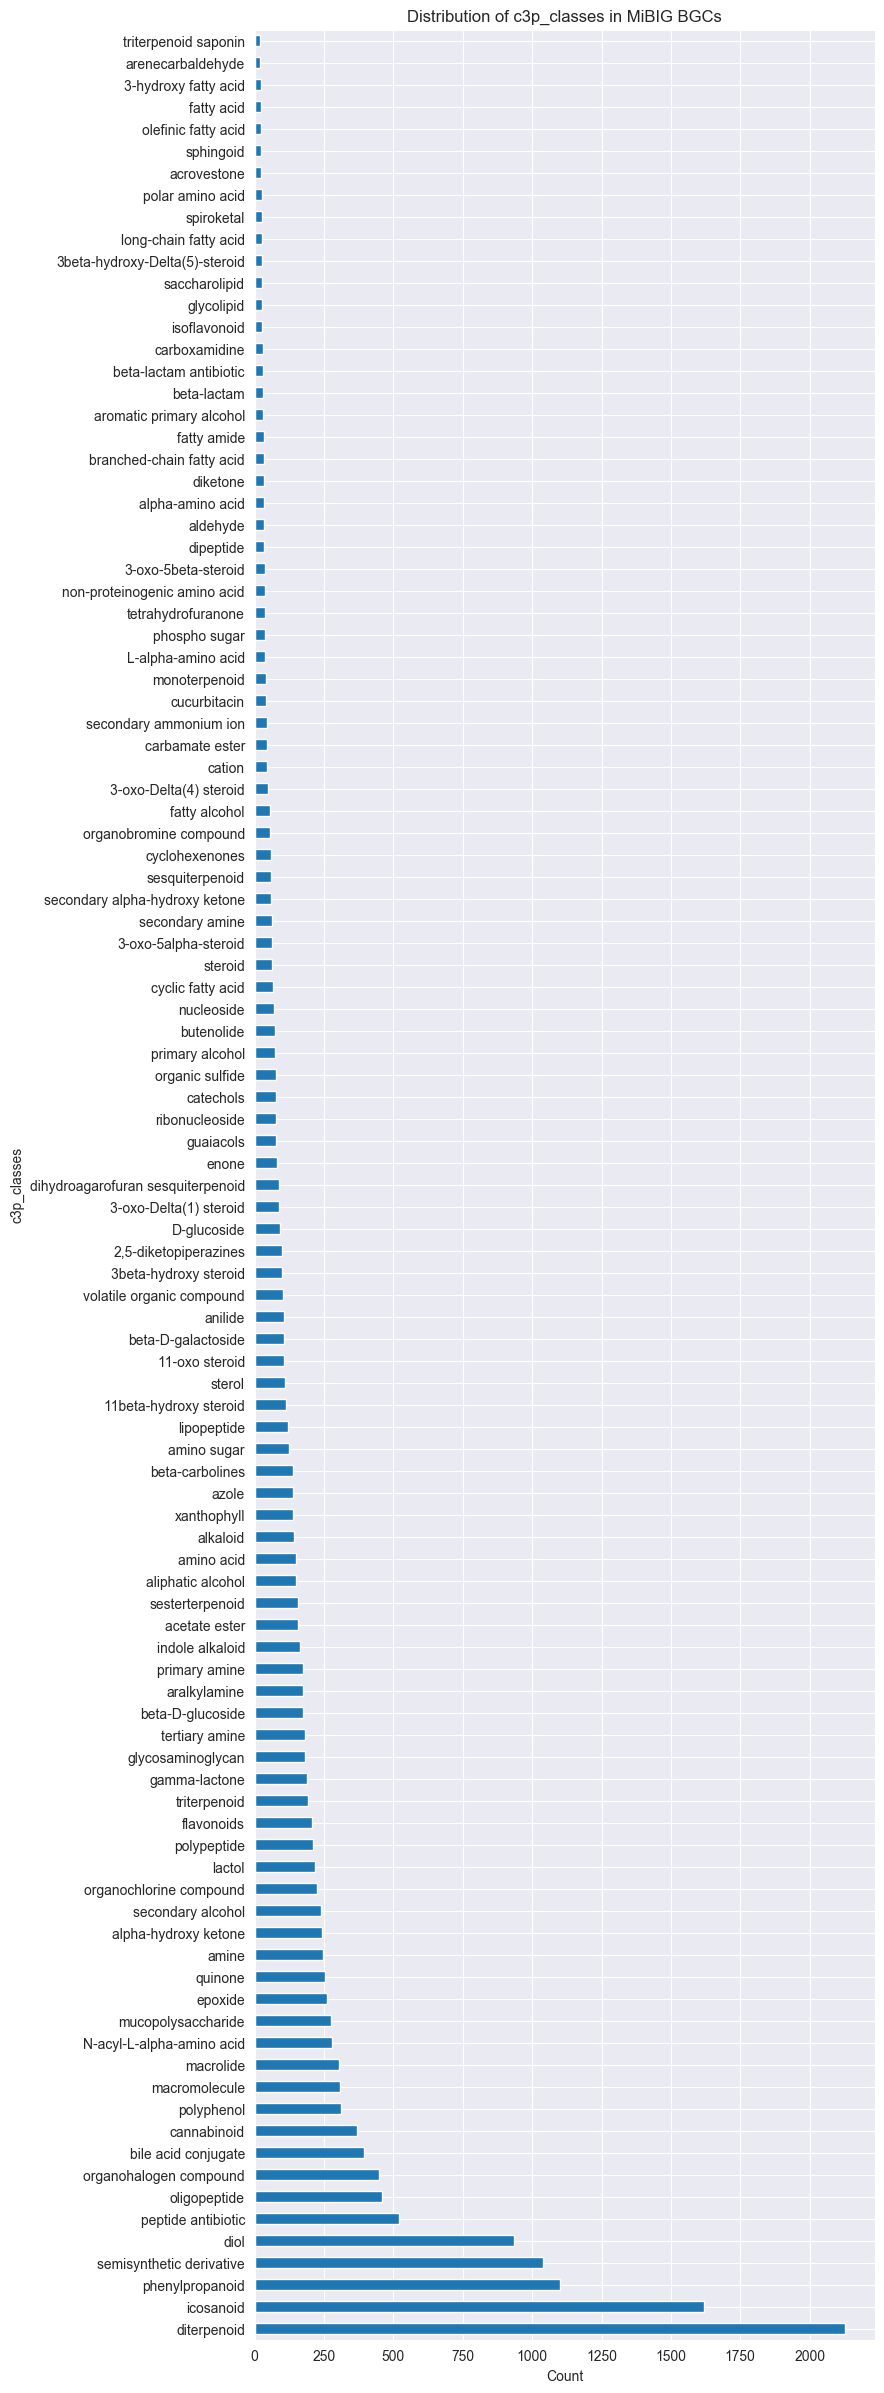

In [95]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_class_distribution(data, column_name="c3p_classes", title=None, min_count=20):
    
    if not title:
        title = f"Distribution of {column_name}"
    # Convert to DataFrame
    df = pd.DataFrame(data)
    
    # Flatten c3p_classes column for analysis
    c3p_classes_flat = [item for sublist in df[column_name] for item in sublist]
    
    
    # Count occurrences of each class
    c3p_class_counts = pd.Series(c3p_classes_flat).value_counts()
    # filter to be at least N
    c3p_class_counts = c3p_class_counts[c3p_class_counts > min_count]
    
    # Re-plot the bar chart with c3p_classes on y-axis (horizontal bar chart)
    plt.figure(figsize=(8, 30))
    c3p_class_counts.plot(kind='barh')
    plt.ylabel(column_name)
    plt.xlabel("Count")
    plt.title(title)
    plt.show()

plot_class_distribution(df, column_name="c3p_classes", title="Distribution of c3p_classes in MiBIG BGCs")



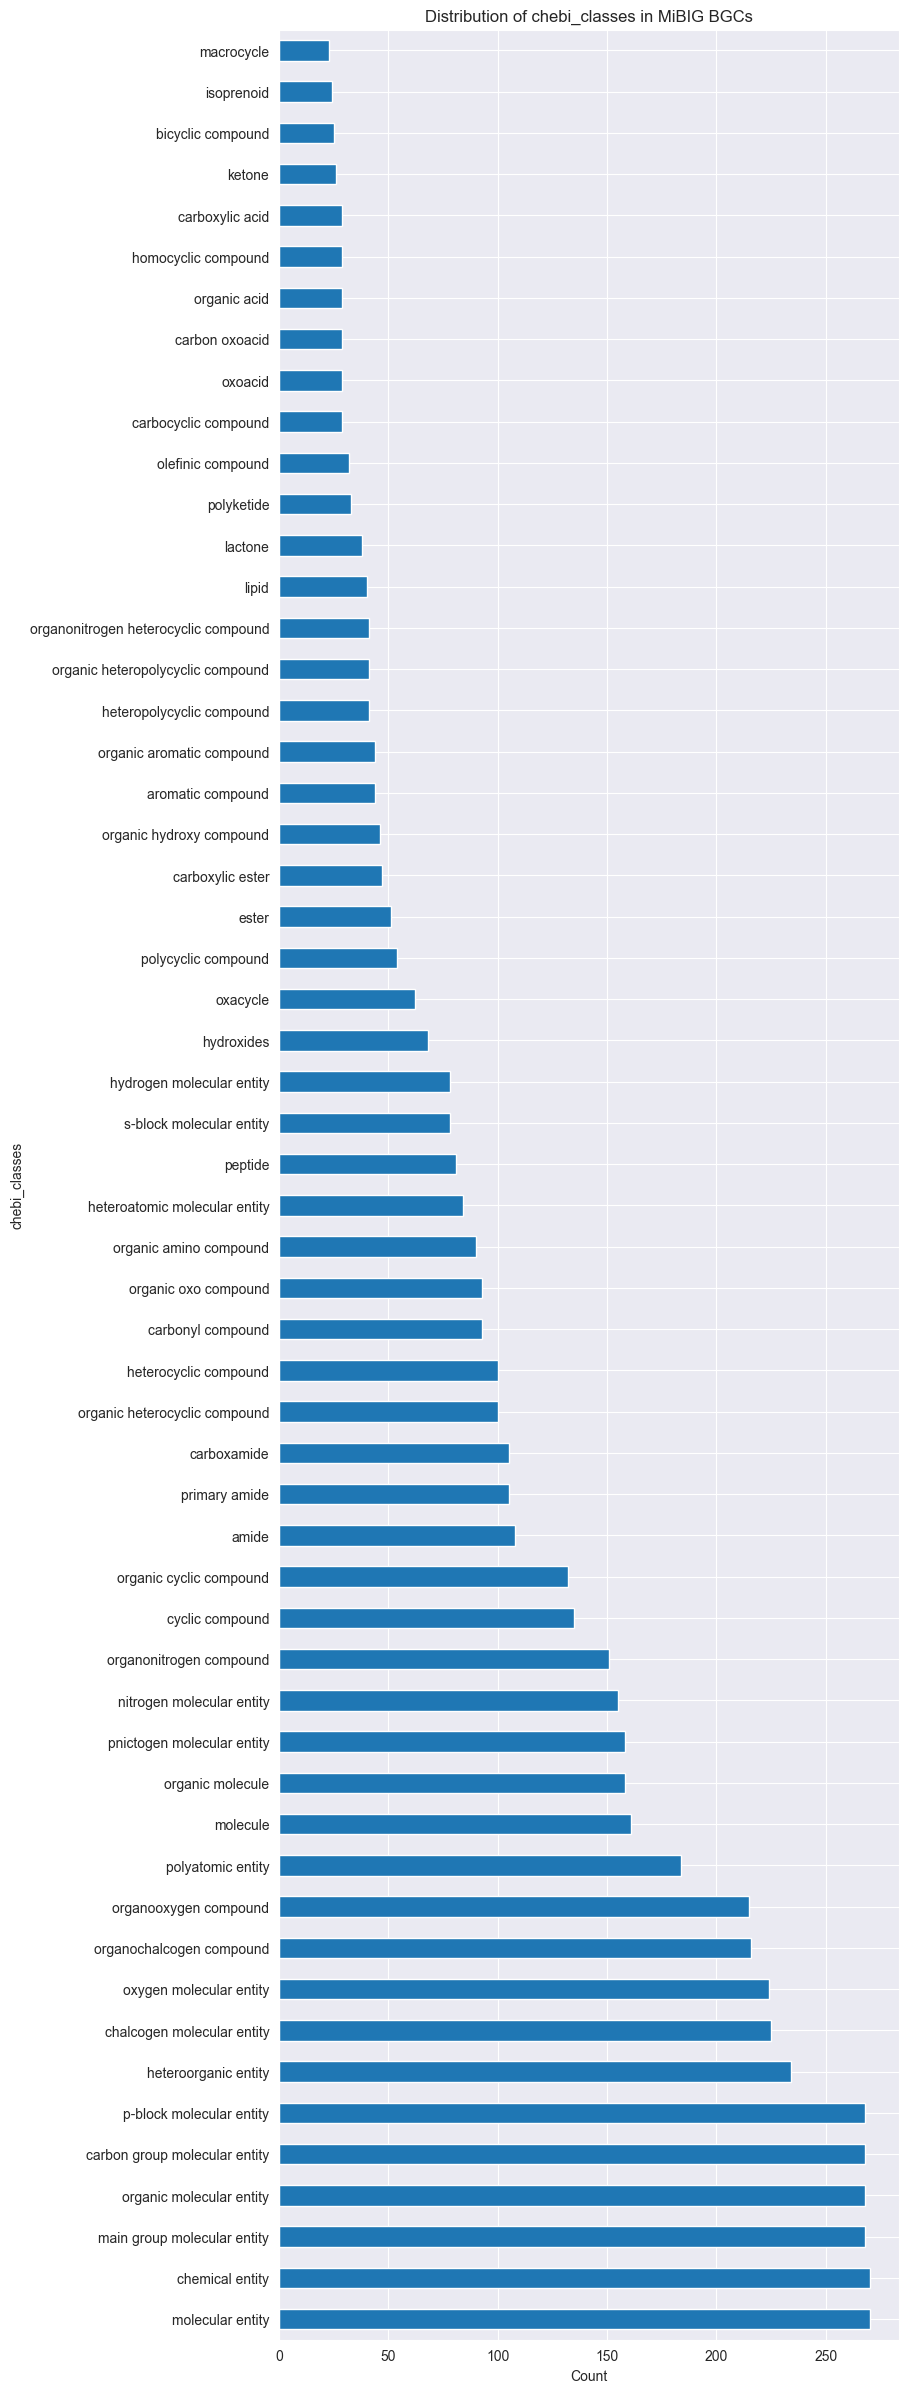

In [96]:
plot_class_distribution(df, column_name="chebi_classes", title="Distribution of chebi_classes in MiBIG BGCs")


In [ ]:
plot_class_distribution(df, column_name="chebifier_classes", title="Distribution of chebi_classes in MiBIG BGCs")


In [ ]:
plot_class_distribution(df, column_name="chebi_classes", title="Distribution of chebi_classes in MiBIG BGCs")


In [25]:
from collections import Counter, defaultdict
import itertools

# Count occurrences of each (class, c3p_class) pair
pair_counts = Counter(itertools.chain.from_iterable(
    itertools.product(cls_list, c3p_list) for cls_list, c3p_list in zip(df["classes"], df["c3p_classes"])
))

# Convert to DataFrame
correlation_counts_df = pd.DataFrame(pair_counts.items(), columns=["Pair", "Count"])

# Split tuple into separate columns
correlation_counts_df[["classes", "c3p_classes"]] = pd.DataFrame(correlation_counts_df["Pair"].tolist(), index=correlation_counts_df.index)
correlation_counts_df.drop(columns=["Pair"], inplace=True)

# Normalize scores by maximum count to show relative correlation strength
correlation_counts_df["Score"] = correlation_counts_df["Count"] / correlation_counts_df["Count"].max()

# Sort by Score
correlation_counts_df = correlation_counts_df.sort_values(by="Score", ascending=False)

correlation_counts_df



,Count,classes,c3p_classes,Score
8,487,PKS,icosanoid,1.000000
19,408,NRPS,icosanoid,0.837782
22,226,PKS,diterpenoid,0.464066
24,194,PKS,alpha-hydroxy ketone,0.398357
20,171,NRPS,diterpenoid,0.351129
...,...,...,...,...
197,1,NRPS,arenecarbaldehyde,0.002053
204,1,PKS,cyclohexenones,0.002053
266,1,NRPS,prenylquinone,0.002053
205,1,PKS,tertiary amine oxide,0.002053


In [26]:
import seaborn as sns

# Convert to DataFrame for heatmap
correlation_df = pd.DataFrame([(cls, c3p) for cls, c3p_list in class_c3p_mapping.items() for c3p in c3p_list], columns=["classes", "c3p_classes"])


# Create a contingency table
contingency_table = correlation_df.pivot_table(index="classes", columns="c3p_classes", aggfunc="size", fill_value=0)

# Compute row-wise percentages
row_totals = contingency_table.sum(axis=1)
percentage_matrix = (contingency_table.div(row_totals, axis=0) * 100).fillna(0)

# Plot the heatmap with percentages
plt.figure(figsize=(10, 6))
sns.heatmap(percentage_matrix, annot=True, cmap="Blues", linewidths=0.5, fmt=".1f", center=0)
plt.xlabel("c3p_classes")
plt.ylabel("classes")
plt.title("Percentage-Based Heatmap: c3p_classes within Each Class")
plt.show()

NameError: name 'class_c3p_mapping' is not defined

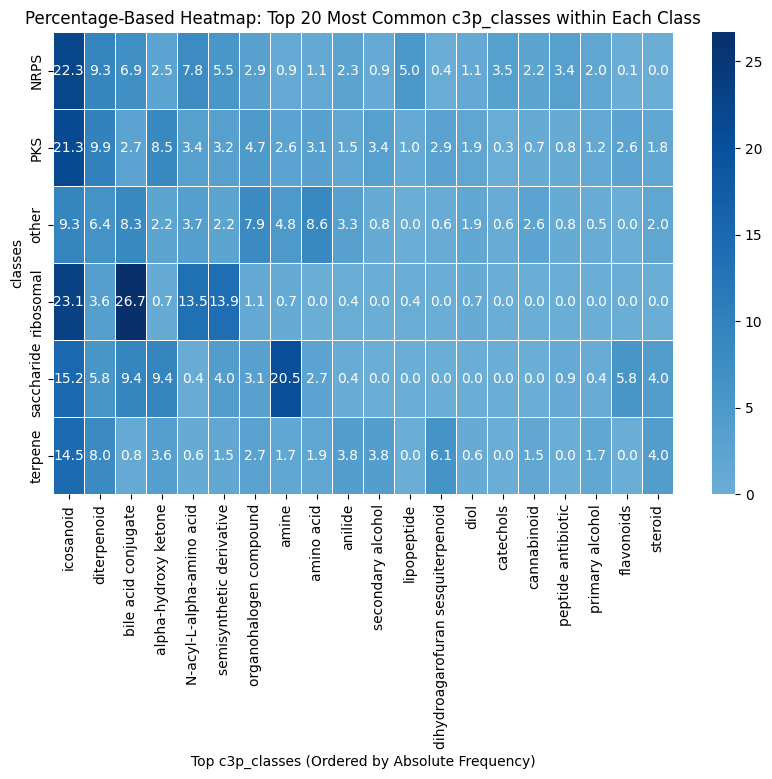

In [87]:
# Recalculate the top N c3p_classes based on total occurrences (from earlier c3p_class_counts)
N = 20
c3p_classes_flat = [item for sublist in df["c3p_classes"] for item in sublist]
c3p_class_counts = pd.Series(c3p_classes_flat).value_counts()
top_c3p_classes = c3p_class_counts.nlargest(N).index

# Filter the percentage matrix for the selected top c3p_classes
filtered_percentage_matrix = percentage_matrix[top_c3p_classes]

# Order x-axis by most common c3p_classes (absolute occurrences)
sorted_c3p_classes = c3p_class_counts[top_c3p_classes].sort_values(ascending=False).index
filtered_percentage_matrix = filtered_percentage_matrix[sorted_c3p_classes]

# Plot the updated heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(filtered_percentage_matrix, annot=True, cmap="Blues", linewidths=0.5, fmt=".1f", center=0)
plt.xlabel("Top c3p_classes (Ordered by Absolute Frequency)")
plt.ylabel("classes")
plt.title(f"Percentage-Based Heatmap: Top {N} Most Common c3p_classes within Each Class")
plt.savefig("mibig/mibig_pct.png", dpi=300, bbox_inches="tight")
plt.show()


In [27]:
# Recalculate the top N c3p_classes based on total occurrences (from earlier c3p_class_counts)
N = 20
chebi_classes_flat = [item for sublist in df["chebi_classes"] for item in sublist]
chebi_class_counts = pd.Series(chebi_classes_flat).value_counts()
top_chebi_classes = chebi_class_counts.nlargest(N).index

# Filter the percentage matrix for the selected top chebi_classes
filtered_percentage_matrix = percentage_matrix[top_chebi_classes]

# Order x-axis by most common chebi_classes (absolute occurrences)
sorted_chebi_classes = chebi_class_counts[top_chebi_classes].sort_values(ascending=False).index
filtered_percentage_matrix = filtered_percentage_matrix[sorted_chebi_classes]

# Plot the updated heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(filtered_percentage_matrix, annot=True, cmap="Blues", linewidths=0.5, fmt=".1f", center=0)
plt.xlabel("Top chebi_classes (Ordered by Absolute Frequency)")
plt.ylabel("classes")
plt.title(f"Percentage-Based Heatmap: Top {N} Most Common chebi_classes within Each Class")
plt.savefig("mibig/mibig_pct.png", dpi=300, bbox_inches="tight")
plt.show()


NameError: name 'percentage_matrix' is not defined

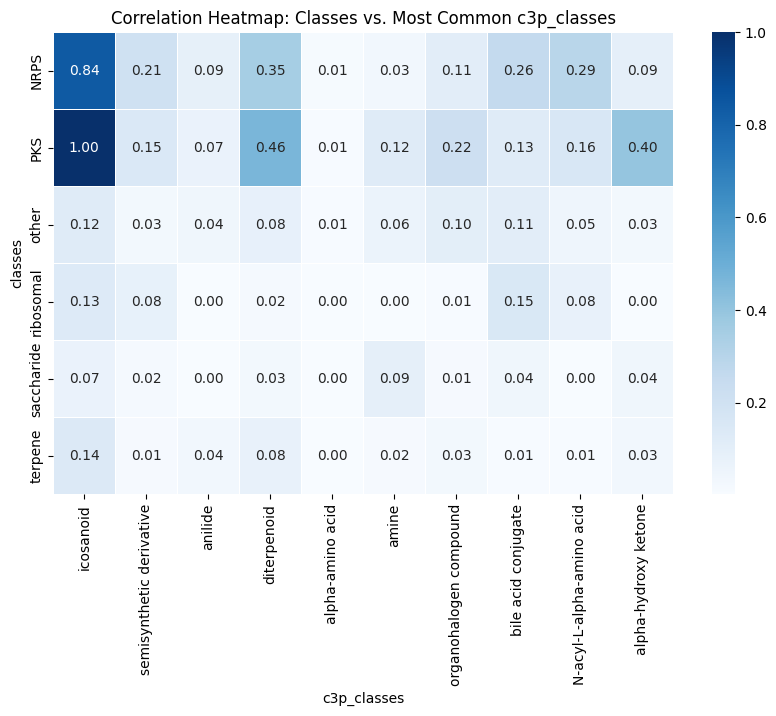

In [67]:
import seaborn as sns
import numpy as np

# Select the N most common c3p_classes
N = 10  # Adjustable number of most common c3p_classes to include
top_c3p_classes = correlation_counts_df["c3p_classes"].value_counts().index[:N]

# Create a pivot table for the heatmap
heatmap_data = correlation_counts_df.pivot(index="classes", columns="c3p_classes", values="Score")

# Filter to only include the most common c3p_classes
heatmap_data = heatmap_data[top_c3p_classes]

# Replace NaN with 0 for visualization
heatmap_data = heatmap_data.fillna(0)

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap="Blues", linewidths=0.5, fmt=".2f")
plt.xlabel("c3p_classes")
plt.ylabel("classes")
plt.title("Correlation Heatmap: Classes vs. Most Common c3p_classes")
plt.show()


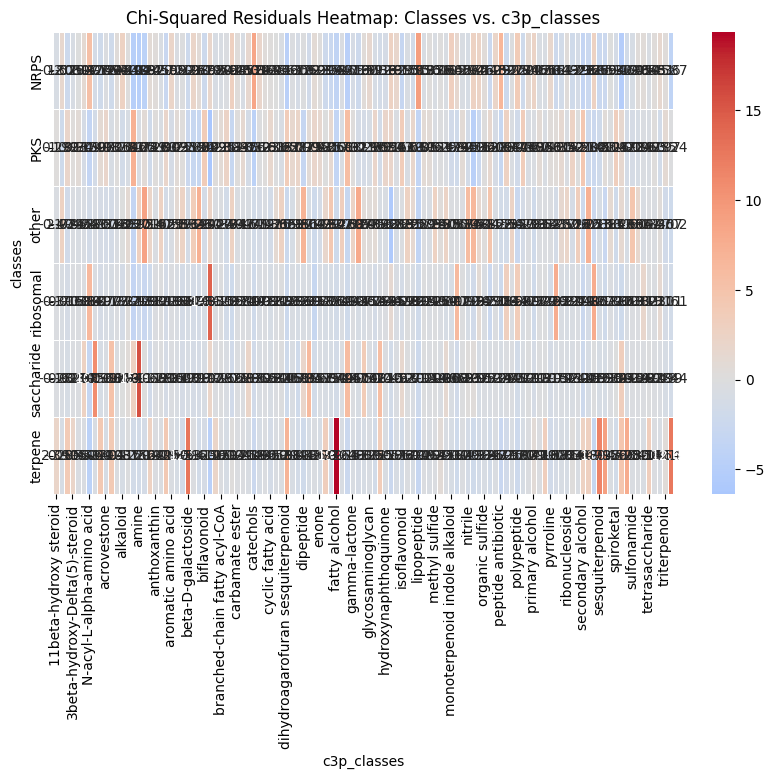

In [68]:
from scipy.stats import chi2_contingency

# Create a contingency table (counts of occurrences for each class-c3p_class pair)
contingency_table = correlation_counts_df.pivot(index="classes", columns="c3p_classes", values="Count").fillna(0)

# Perform Chi-Squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Convert expected counts to a DataFrame
expected_df = pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns)

# Compute Chi-Squared residuals (observed - expected) / sqrt(expected)
chi_squared_residuals = (contingency_table - expected_df) / (expected_df ** 0.5)

# Plot the heatmap using Chi-Squared residuals
plt.figure(figsize=(10, 6))
sns.heatmap(chi_squared_residuals, annot=True, cmap="coolwarm", linewidths=0.5, fmt=".2f", center=0)
plt.xlabel("c3p_classes")
plt.ylabel("classes")
plt.title("Chi-Squared Residuals Heatmap: Classes vs. c3p_classes")
plt.show()


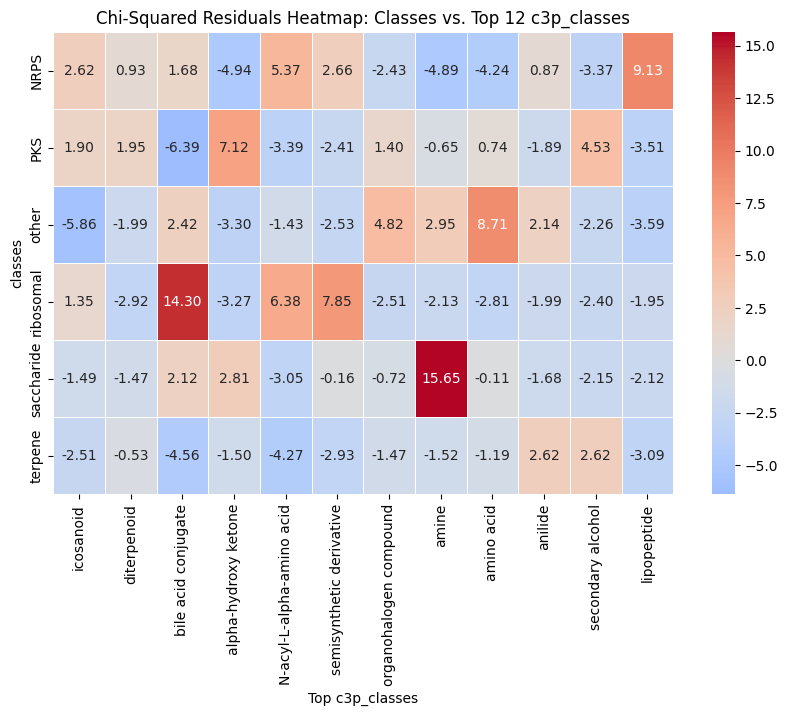

In [72]:
# Select the top N most common c3p_classes based on occurrences
N = 12
top_c3p_classes = contingency_table.sum().nlargest(N).index

# Filter the contingency table and chi-squared residuals for these top classes
filtered_contingency = contingency_table[top_c3p_classes]
filtered_chi_squared_residuals = chi_squared_residuals[top_c3p_classes]

# Plot the heatmap again with the filtered data
plt.figure(figsize=(10, 6))
sns.heatmap(filtered_chi_squared_residuals, annot=True, cmap="coolwarm", linewidths=0.5, fmt=".2f", center=0)
plt.xlabel("Top c3p_classes")
plt.ylabel("classes")
plt.title(f"Chi-Squared Residuals Heatmap: Classes vs. Top {N} c3p_classes")
plt.savefig("mibig/mibig_corr.png", dpi=300, bbox_inches="tight")
plt.show()


<Figure size 640x480 with 0 Axes>